<a href="https://colab.research.google.com/github/svetlanama/goit-np-hw-01/blob/main/NP_HW_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Визначте DataFrame з тривимірними векторами слів:

Завантажте модель word embeddings, використовуючи файл, який містить NLP модель.
Витягніть тривимірні вектори для всіх слів з цієї моделі.
Створіть DataFrame, в якому буде міститися інформація про слова та їхні тривимірні вектори.

In [40]:

# Імпорт потрібних бібліотек
import pandas as pd
import io, re, math, gzip, pathlib, statistics
import pickle # Python object serialization library. Not secure
from google.colab import drive
from sklearn.decomposition import PCA

drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [37]:
word_embeddings = pickle.load( open('/content/drive/MyDrive/neo_data/word_embeddings_subset.p', "rb"))

len(word_embeddings) # there should be 243 words that will be used in this assignment

243

In [41]:
# Перевіримо, що це словник word -> np.array
print(type(word_embeddings), len(word_embeddings))  # очікуємо ~243 слів

# 2) Готуємо матрицю ембеддингів
words = list(word_embeddings.keys())
X = np.vstack([np.asarray(word_embeddings[w]) for w in words])  # shape: (N, D)
N, D = X.shape
print(f"N={N} words, D={D} dims")

# 3) Отримуємо 3D-вектори:
#    - якщо вже 3D, беремо як є
#    - інакше зменшуємо до 3 через PCA (стандартний і швидкий для візуалізації/таблиць)
if D == 3:
    X3 = X
else:
    pca = PCA(n_components=3, random_state=42)
    X3 = pca.fit_transform(X)

# 4) Створюємо DataFrame
df_3d = pd.DataFrame({
    'word': words,
    'x': X3[:, 0],
    'y': X3[:, 1],
    'z': X3[:, 2],
})

# (необов’язково) Відсортуємо для стабільності
df_3d = df_3d.sort_values('word').reset_index(drop=True)

# 5) Перевірки/вивід
print(df_3d.shape)
df_3d.head()

<class 'dict'> 243
N=243 words, D=300 dims
(243, 4)


,word,x,y,z
0,Abuja,-1.561085,-1.144419,0.515586
1,Accra,-1.602932,-0.845107,0.384880
2,Afghanistan,0.751223,-0.240383,-0.055846
3,Albania,1.102844,0.450449,0.785021
4,Algeria,0.869988,-0.771020,0.824030


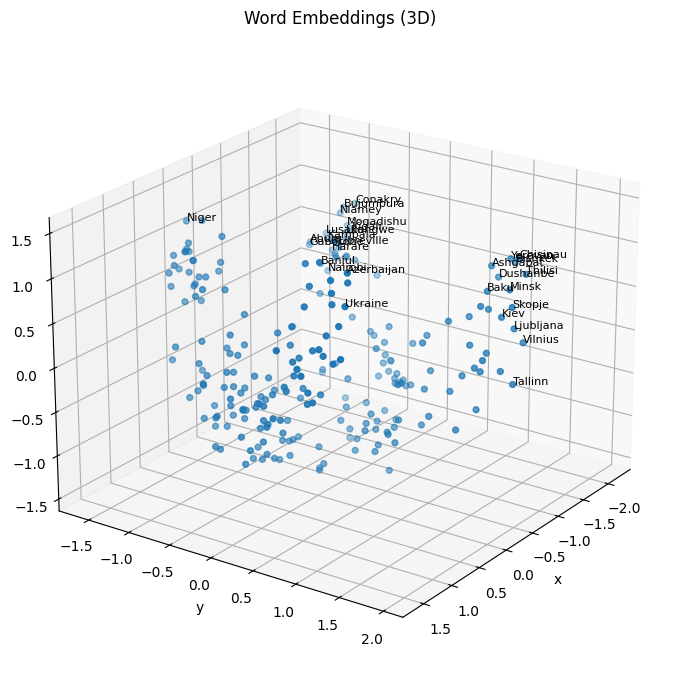

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (необхідний імпорт для 3D)

def plot_embeddings_3d(
    df_3d,
    annotate=True,
    max_labels=30,
    label_words=None,
    elev=22,
    azim=35,
    s=18,
    figsize=(8, 7)
):
    """
    3D-скатерплот для df_3d з колонками ['word','x','y','z'].

    annotate   : підписувати частину точок
    max_labels : скільки підписів показати (якщо label_words не задано)
    label_words: конкретні слова для підпису (список рядків)
    elev, azim : ракурс камери
    s          : розмір маркерів
    """

    X = df_3d[['x','y','z']].to_numpy()
    words = df_3d['word'].tolist()

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(X[:,0], X[:,1], X[:,2], s=s)

    # Акуратне підписування (щоб не захаращувати):
    if annotate:
        if label_words:
            label_set = set(label_words)
            idxs = [i for i,w in enumerate(words) if w in label_set]
        else:
            # Виберемо слова, що найдалі від центроїда (краще видно на графіку)
            centroid = X.mean(axis=0)
            d = np.linalg.norm(X - centroid, axis=1)
            idxs = np.argsort(-d)[:min(max_labels, len(words))]

        for i in idxs:
            ax.text(X[i,0], X[i,1], X[i,2], words[i],
                    fontsize=8)

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.view_init(elev=elev, azim=azim)
    plt.title('Word Embeddings (3D)')
    plt.tight_layout()
    plt.show()

# Виклик (базовий):
plot_embeddings_3d(df_3d)

# Приклад із підписами лише конкретних слів:
# plot_embeddings_3d(df_3d, label_words=['king','queen','man','woman','paris','france'])


2. Визначте функції для пошуку найближчого слова:

Напишіть функцію, яка приймає тривимірний вектор та знаходить найближче слово в моделі word embeddings_subset.
Використайте цю функцію для кількох прикладів та переконайтеся, що результати є коректними.

In [50]:
import numpy as np

# 0) Підготуємо матрицю та довідники
WORDS = df_3d['word'].tolist()
X3 = df_3d[['x', 'y', 'z']].to_numpy()            # shape: (N, 3)

def _normalize_rows(X: np.ndarray) -> np.ndarray:
    norms = np.linalg.norm(X, axis=1, keepdims=True)
    norms = np.where(norms == 0, 1.0, norms)      # захист від ділення на 0
    return X / norms

X3_norm = _normalize_rows(X3)                     # для cosine
WORD2IDX = {w: i for i, w in enumerate(WORDS)}

# 1) Пошук за довільним 3D-вектором
def nearest_by_vector(vec3: np.ndarray, k: int = 1, metric: str = 'cosine', exclude: list[str] | None = None):
    """
    vec3: np.array форми (3,)
    k: скільки найближчих повернути
    metric: 'cosine' або 'euclidean'
    exclude: список слів, які потрібно виключити з результату (наприклад, саме слово)
    """
    vec3 = np.asarray(vec3).reshape(-1)
    assert vec3.shape == (3,), "vec3 має бути форми (3,)"

    N = X3.shape[0]
    mask = np.ones(N, dtype=bool)
    if exclude:
        for w in exclude:
            idx = WORD2IDX.get(w)
            if idx is not None:
                mask[idx] = False

    if metric == 'cosine':
        v = vec3 / (np.linalg.norm(vec3) or 1.0)
        sims = (X3_norm @ v)                      # cos similarity
        sims_masked = np.where(mask, sims, -np.inf)
        # топ-k за спаданням схожості
        k_eff = min(k, np.isfinite(sims_masked).sum())
        topk_idx = np.argpartition(-sims_masked, kth=k_eff-1)[:k_eff]
        topk_idx = topk_idx[np.argsort(-sims_masked[topk_idx])]
        return [(WORDS[i], float(sims[i])) for i in topk_idx]

    elif metric == 'euclidean':
        dists = np.linalg.norm(X3 - vec3, axis=1)
        dists_masked = np.where(mask, dists, np.inf)
        k_eff = min(k, np.isfinite(dists_masked).sum())
        topk_idx = np.argpartition(dists_masked, kth=k_eff-1)[:k_eff]
        topk_idx = topk_idx[np.argsort(dists_masked[topk_idx])]
        return [(WORDS[i], float(dists[i])) for i in topk_idx]

    else:
        raise ValueError("metric має бути 'cosine' або 'euclidean'")

# 2) Пошук за словом (зручний шорткат)
def vector_of(word: str) -> np.ndarray:
    """Повертає 3D-вектор слова з df_3d."""
    idx = WORD2IDX.get(word)
    if idx is None:
        raise KeyError(f"Слова '{word}' немає в словнику.")
    return X3[idx]

def nearest_to_word(word: str, k: int = 5, metric: str = 'cosine'):
    """Найближчі слова до заданого слова (без самого слова у видачі)."""
    v = vector_of(word)
    return nearest_by_vector(v, k=k, metric=metric, exclude=[word])


In [51]:
# Візьмемо будь-яке слово з набору
test_word = WORDS[0]
# Без exclude -> перший результат має збігатись зі словом
res_self = nearest_by_vector(vector_of(test_word), k=1, metric='cosine', exclude=None)
print("Self check:", test_word, "->", res_self[0])

assert res_self[0][0] == test_word, "Top-1 має бути те саме слово (self-check провалився)"


Self check: Abuja -> ('Abuja', 1.0)


In [52]:
for w in WORDS[:3]:  # кілька перших слів як приклади
    print(f"\nНайближчі до '{w}' (cosine):")
    print(nearest_to_word(w, k=5, metric='cosine'))

    print(f"Найближчі до '{w}' (euclidean):")
    print(nearest_to_word(w, k=5, metric='euclidean'))



Найближчі до 'Abuja' (cosine):
[('Gaborone', 0.9999873638153076), ('Lusaka', 0.9968248605728149), ('Kampala', 0.9960655570030212), ('Dakar', 0.9943804144859314), ('Maputo', 0.9906014204025269)]
Найближчі до 'Abuja' (euclidean):
[('Gaborone', 0.05737831071019173), ('Kampala', 0.2232474386692047), ('Lusaka', 0.2520746886730194), ('Banjul', 0.2825263440608978), ('Libreville', 0.29563239216804504)]

Найближчі до 'Accra' (cosine):
[('Maputo', 0.9995267391204834), ('Lilongwe', 0.9990275502204895), ('Harare', 0.9987924695014954), ('Libreville', 0.9986041188240051), ('Kampala', 0.9978670477867126)]
Найближчі до 'Accra' (euclidean):
[('Maputo', 0.057955216616392136), ('Libreville', 0.15821518003940582), ('Nouakchott', 0.17242367565631866), ('Nairobi', 0.24942204356193542), ('Banjul', 0.25577083230018616)]

Найближчі до 'Afghanistan' (cosine):
[('Venezuela', 0.9907379746437073), ('Portugal', 0.9899588823318481), ('Uruguay', 0.987541913986206), ('Ecuador', 0.987482488155365), ('Qatar', 0.9829792

In [53]:
def try_analogy(a: str, b: str, c: str, k: int = 5, metric: str = 'cosine'):
    """
    Знаходимо x:  b - a + c  ~ x
    Повертаємо k найближчих слів.
    """
    v = vector_of(b) - vector_of(a) + vector_of(c)
    return nearest_by_vector(v, k=k, metric=metric, exclude=[a, b, c])

# Приклад (якщо такі слова є в підмножині):
# print(try_analogy("man", "king", "woman", k=5))


3. Обчисліть векторний добуток для знаходження ортогонального слова:

Виберіть декілька довільних пар слів.
Обчисліть векторний добуток для кожної пари слів та використайте раніше написану функцію для знаходження найближчого слова.
Проаналізуйте результати та спробуйте їх інтерпретувати.

In [54]:
import numpy as np

def angle_deg(u, v):
    """Кут між векторами у градусах (0° = паралельні, 90° = ортогональні)."""
    u = np.asarray(u); v = np.asarray(v)
    nu = np.linalg.norm(u); nv = np.linalg.norm(v)
    if nu == 0 or nv == 0:
      return np.nan
    cosang = np.clip(u.dot(v) / (nu * nv), -1.0, 1.0)
    return float(np.degrees(np.arccos(cosang)))

def cross_of_words(a: str, b: str, normalize: bool = True):
    """
    Векторний добуток двох слів у 3D.
    Повертає (v_cross, info), де info містить кут між a і b та 'силу' ортогональності (sinθ).
    """
    va, vb = vector_of(a), vector_of(b)
    v = np.cross(va, vb)                   # ортогональний до площини (va, vb)
    norm_v = np.linalg.norm(v)
    # sin(theta) = ||va x vb|| / (||va|| * ||vb||)
    sin_theta = norm_v / (np.linalg.norm(va) * np.linalg.norm(vb) + 1e-12)
    if normalize and norm_v > 0:
        v = v / norm_v

    info = {
        "angle_deg": angle_deg(va, vb),
        "sin_theta": float(sin_theta),     # 0 ~ майже паралельні, 1 ~ майже ортогональні
        "norm_cross": float(norm_v)
    }
    return v, info

def nearest_to_cross(a: str, b: str, k: int = 5, metric: str = 'cosine', exclude_self=True):
    """
    Знаходить найближчі слова до векторного добутку (a × b).
    exclude_self=True — виключає самі a і b з видачі.
    """
    v, info = cross_of_words(a, b, normalize=True)
    exclude = [a, b] if exclude_self else None
    neigh = nearest_by_vector(v, k=k, metric=metric, exclude=exclude)
    return info, neigh


In [55]:
pairs = [(WORDS[i], WORDS[i+1]) for i in range(0, min(6, len(WORDS)-1), 2)]

for a, b in pairs:
    info, neigh = nearest_to_cross(a, b, k=5, metric='cosine', exclude_self=True)
    print(f"\n=== {a!r} × {b!r} ===")
    print(f"Кут(a,b) ≈ {info['angle_deg']:.1f}°, sinθ ≈ {info['sin_theta']:.3f}, ||a×b|| ≈ {info['norm_cross']:.3f}")
    print("Топ-5 найближчих до (a×b):")
    for w, score in neigh:
        print(f"  {w:20s}  sim={score:.4f}")



=== 'Abuja' × 'Accra' ===
Кут(a,b) ≈ 8.7°, sinθ ≈ 0.152, ||a×b|| ≈ 0.562
Топ-5 найближчих до (a×b):
  Roseau                sim=0.9985
  Kingston              sim=0.9945
  Funafuti              sim=0.9872
  Nassau                sim=0.9759
  Georgetown            sim=0.9697

=== 'Afghanistan' × 'Albania' ===
Кут(a,b) ≈ 53.2°, sinθ ≈ 0.800, ||a×b|| ≈ 0.903
Топ-5 найближчих до (a×b):
  Burundi               sim=0.9817
  Niger                 sim=0.9764
  Rwanda                sim=0.9610
  Somalia               sim=0.9529
  Malawi                sim=0.9452

=== 'Algeria' × 'Algiers' ===
Кут(a,b) ≈ 116.7°, sinθ ≈ 0.893, ||a×b|| ≈ 1.442
Топ-5 найближчих до (a×b):
  Samoa                 sim=0.9645
  Belize                sim=0.9413
  petroleum             sim=0.9345
  Roseau                sim=0.9302
  Kingston              sim=0.9177


==== 4 ====

In [56]:
import numpy as np

def orthogonal_word(w1: str, w2: str, k: int = 5, metric: str = 'cosine'):
    """
    Знаходить слово(-а), чий 3D-вектор найближчий до векторного добутку v1 × v2,
    тобто приблизно ортогональний і до w1, і до w2 (у 3D-просторі).
    Повертає:
      {
        'w1': ..., 'w2': ...,
        'best': [(word, score), ...],     # топ-k для v = v1×v2
        'best_neg': [(word, score), ...], # топ-k для -v (бо напрямок невизначений)
        'norm': float
      }
    """
    v1, v2 = vector_of(w1), vector_of(w2)
    v = np.cross(v1, v2)               # вектор перпендикулярний до площини (v1, v2)
    n = np.linalg.norm(v)
    if n < 1e-12:
        return {
            'w1': w1, 'w2': w2, 'norm': float(n),
            'best': [], 'best_neg': [],
            'note': 'Вектори майже колінеарні -> добуток ~ 0, ортогональність не визначена'
        }
    best = nearest_by_vector(v, k=k, metric=metric, exclude=[w1, w2])
    best_neg = nearest_by_vector(-v, k=k, metric=metric, exclude=[w1, w2])
    return {'w1': w1, 'w2': w2, 'best': best, 'best_neg': best_neg, 'norm': float(n)}

# Приклади (візьмемо кілька перших слів з вашого словника)
examples_pairs = [(WORDS[i], WORDS[i+1]) for i in range(0, min(6, len(WORDS)-1), 2)]
for a,b in examples_pairs:
    res = orthogonal_word(a, b, k=5, metric='cosine')
    print(f"\n[{a} ⨯ {b}]  |‖v1×v2‖={res['norm']:.4f}")
    print(" top(v):     ", res['best'])
    print(" top(-v):    ", res['best_neg'])



[Abuja ⨯ Accra]  |‖v1×v2‖=0.5624
 top(v):      [('Roseau', 0.9985203146934509), ('Kingston', 0.9944548010826111), ('Funafuti', 0.9871655702590942), ('Nassau', 0.975907027721405), ('Georgetown', 0.9697108864784241)]
 top(-v):     [('Kyrgyzstan', 0.9730082750320435), ('Turkmenistan', 0.9081628322601318), ('Tajikistan', 0.8994070887565613), ('Azerbaijan', 0.8761230111122131), ('Armenia', 0.8729199171066284)]

[Afghanistan ⨯ Albania]  |‖v1×v2‖=0.9029
 top(v):      [('Burundi', 0.981663703918457), ('Niger', 0.9763672351837158), ('Rwanda', 0.9610463976860046), ('Somalia', 0.9529284238815308), ('Malawi', 0.9452148675918579)]
 top(-v):     [('Athens', 0.9849274158477783), ('Lisbon', 0.972941517829895), ('Berlin', 0.9707467555999756), ('Dublin', 0.9188722372055054), ('Rome', 0.9106416702270508)]

[Algeria ⨯ Algiers]  |‖v1×v2‖=1.4425
 top(v):      [('Samoa', 0.9644500017166138), ('Belize', 0.9413187503814697), ('petroleum', 0.9345304369926453), ('Roseau', 0.9301725029945374), ('Kingston', 0.917

In [57]:
def angle_between_words(w1: str, w2: str, degrees: bool = True):
    """
    Рахує кут між нормалізованими 3D-векторами слів w1 і w2.
    Повертає (angle, cosine_similarity).
    """
    v1 = vector_of(w1); v2 = vector_of(w2)
    v1n = v1 / (np.linalg.norm(v1) or 1.0)
    v2n = v2 / (np.linalg.norm(v2) or 1.0)
    cos_sim = float(np.clip(np.dot(v1n, v2n), -1.0, 1.0))
    ang = np.arccos(cos_sim)
    if degrees:
        ang = float(np.degrees(ang))
    return ang, cos_sim

# Швидкі тести на різних парах (використаємо кілька перших слів)
test_pairs = []
L = min(8, len(WORDS))
for i in range(L):
    for j in range(i+1, L):
        test_pairs.append((WORDS[i], WORDS[j]))

for (a,b) in test_pairs[:6]:  # покажемо перші кілька
    ang, c = angle_between_words(a,b, degrees=True)
    print(f"{a:>15} ↔ {b:<15}  angle={ang:6.2f}°   cos={c:+.3f}")


          Abuja ↔ Accra            angle=  8.72°   cos=+0.988
          Abuja ↔ Afghanistan      angle=125.80°   cos=-0.585
          Abuja ↔ Albania          angle=129.88°   cos=-0.641
          Abuja ↔ Algeria          angle= 91.02°   cos=-0.018
          Abuja ↔ Algiers          angle= 25.69°   cos=+0.901
          Abuja ↔ Amman            angle= 73.21°   cos=+0.289
